# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

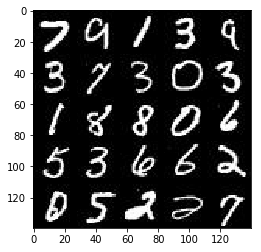

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

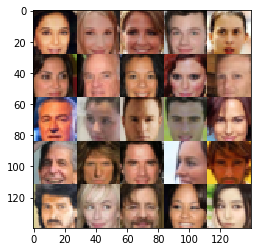

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=None, name='learning_rate')
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # @ could add dropout between layers to prevent overfitting/memorization 
#         - slows down training time tho
    # @ use different depths/filters?
    # @ is batch normalization necessary in discriminator?
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        alpha = 0.2
        # images= 28 x 28 
        # first layer: conv2d (filters = 16,32,or64), no batch_norm, leaky relu
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same") # strides for downsampling
        x1 = tf.maximum(alpha*x1, x1)
        # 14 x 14 x 64
        
        # second layer: double depth with new layer, add batch_norm
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7 x 7 x 128
        
        # third layer: set padding 'valid' with no padding: ceil((7-5+1)/2) = 2 
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding="valid")
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 2 x 2 x 256
        
        # flatten:
        flat = tf.reshape(x3, (-1, 2*2*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) # prob. of how real the image is

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # @ relu vs leaky relu
    # @ add dropout around the 1st layer? (0.3 to 0.6)
    
    # takes in a list of values and outputs a picture
    with tf.variable_scope("generator", reuse=not is_train):
        
        alpha = 0.2
        
        # fully-connected
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512)) # flat to 3D
        x1 = tf.layers.batch_normalization(x1, training=is_train) # stabilizes learning
        x1 = tf.maximum(alpha*x1, x1)
        # 7 x 7 x 512
        
        # transposed convolution 1 (inverse of convolution)
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # 14 x 14 x 256
        
        # transposed convolution 2
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding="same")
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # 28 x 28 x 128
        
        # output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding="same")
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # update the generator and discriminator variables separately
    t_vars = tf.trainable_variables() # all variables defined in graph
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # build model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
#     losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, lr:learning_rate})
                # Run g_optim twice to make sure that d_loss does not go to zero
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images, lr:learning_rate})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    # save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0973 Generator Loss: 4.0883
Epoch 1/2... Discriminator Loss: 0.0414 Generator Loss: 3.9627
Epoch 1/2... Discriminator Loss: 3.8368 Generator Loss: 0.0285
Epoch 1/2... Discriminator Loss: 2.1214 Generator Loss: 0.2463
Epoch 1/2... Discriminator Loss: 1.6298 Generator Loss: 0.4292
Epoch 1/2... Discriminator Loss: 1.5381 Generator Loss: 0.4228
Epoch 1/2... Discriminator Loss: 1.9020 Generator Loss: 0.2675
Epoch 1/2... Discriminator Loss: 1.2969 Generator Loss: 0.6120
Epoch 1/2... Discriminator Loss: 1.1174 Generator Loss: 1.2332
Epoch 1/2... Discriminator Loss: 1.1041 Generator Loss: 0.5417


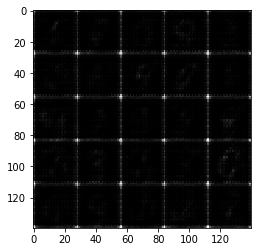

Epoch 1/2... Discriminator Loss: 1.5107 Generator Loss: 0.2973
Epoch 1/2... Discriminator Loss: 0.3933 Generator Loss: 1.4653
Epoch 1/2... Discriminator Loss: 0.5026 Generator Loss: 1.2606
Epoch 1/2... Discriminator Loss: 0.0787 Generator Loss: 3.7976
Epoch 1/2... Discriminator Loss: 0.1313 Generator Loss: 2.8931
Epoch 1/2... Discriminator Loss: 4.8780 Generator Loss: 0.0120
Epoch 1/2... Discriminator Loss: 1.6632 Generator Loss: 0.3414
Epoch 1/2... Discriminator Loss: 1.5318 Generator Loss: 7.4740
Epoch 1/2... Discriminator Loss: 1.6409 Generator Loss: 0.2568
Epoch 1/2... Discriminator Loss: 0.9527 Generator Loss: 0.7529


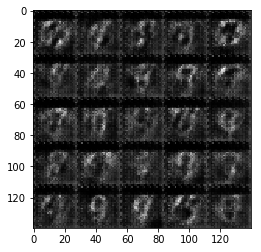

Epoch 1/2... Discriminator Loss: 0.3155 Generator Loss: 3.4935
Epoch 1/2... Discriminator Loss: 0.8445 Generator Loss: 1.0698
Epoch 1/2... Discriminator Loss: 0.3388 Generator Loss: 1.7699
Epoch 1/2... Discriminator Loss: 0.8183 Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 0.2710 Generator Loss: 2.1303
Epoch 1/2... Discriminator Loss: 0.8390 Generator Loss: 0.7945
Epoch 1/2... Discriminator Loss: 0.4906 Generator Loss: 1.9318
Epoch 1/2... Discriminator Loss: 0.3238 Generator Loss: 1.8712
Epoch 1/2... Discriminator Loss: 1.2083 Generator Loss: 0.7312
Epoch 1/2... Discriminator Loss: 1.1069 Generator Loss: 0.7550


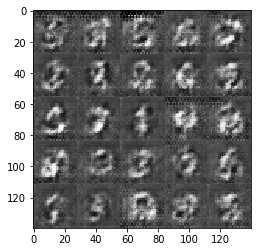

Epoch 1/2... Discriminator Loss: 1.2930 Generator Loss: 0.4082
Epoch 1/2... Discriminator Loss: 0.2511 Generator Loss: 3.7767
Epoch 1/2... Discriminator Loss: 0.2325 Generator Loss: 2.5275
Epoch 1/2... Discriminator Loss: 0.5121 Generator Loss: 2.6059
Epoch 1/2... Discriminator Loss: 0.3443 Generator Loss: 3.0368
Epoch 1/2... Discriminator Loss: 0.9721 Generator Loss: 0.5992
Epoch 1/2... Discriminator Loss: 0.4017 Generator Loss: 2.1178
Epoch 1/2... Discriminator Loss: 0.2038 Generator Loss: 2.4934
Epoch 1/2... Discriminator Loss: 0.2083 Generator Loss: 2.5968
Epoch 1/2... Discriminator Loss: 0.2029 Generator Loss: 2.7254


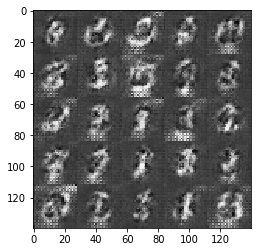

Epoch 1/2... Discriminator Loss: 0.1347 Generator Loss: 3.6848
Epoch 1/2... Discriminator Loss: 1.0695 Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 0.7962 Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 0.1186 Generator Loss: 4.6526
Epoch 1/2... Discriminator Loss: 0.6484 Generator Loss: 1.0848
Epoch 1/2... Discriminator Loss: 0.1374 Generator Loss: 3.4679
Epoch 1/2... Discriminator Loss: 0.9221 Generator Loss: 0.6326
Epoch 1/2... Discriminator Loss: 1.2545 Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 0.3318 Generator Loss: 1.5138
Epoch 1/2... Discriminator Loss: 0.9481 Generator Loss: 0.6859


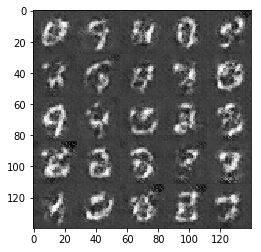

Epoch 1/2... Discriminator Loss: 0.7901 Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 0.8663 Generator Loss: 0.6759
Epoch 1/2... Discriminator Loss: 0.5529 Generator Loss: 1.1015
Epoch 1/2... Discriminator Loss: 1.5860 Generator Loss: 0.6675
Epoch 1/2... Discriminator Loss: 1.2006 Generator Loss: 0.5306
Epoch 1/2... Discriminator Loss: 0.3991 Generator Loss: 2.1825
Epoch 1/2... Discriminator Loss: 0.6139 Generator Loss: 1.0735
Epoch 1/2... Discriminator Loss: 0.1729 Generator Loss: 3.6687
Epoch 1/2... Discriminator Loss: 0.2099 Generator Loss: 2.2328
Epoch 1/2... Discriminator Loss: 0.1840 Generator Loss: 2.9769


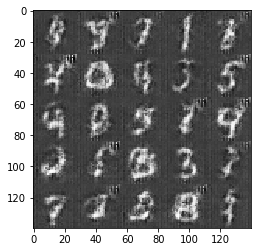

Epoch 1/2... Discriminator Loss: 0.1049 Generator Loss: 5.6923
Epoch 1/2... Discriminator Loss: 0.2923 Generator Loss: 1.6716
Epoch 1/2... Discriminator Loss: 1.6786 Generator Loss: 0.3503
Epoch 1/2... Discriminator Loss: 0.9916 Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 0.9261 Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 0.5216 Generator Loss: 1.6086
Epoch 1/2... Discriminator Loss: 0.5145 Generator Loss: 1.1547
Epoch 1/2... Discriminator Loss: 0.2028 Generator Loss: 2.6572
Epoch 1/2... Discriminator Loss: 1.7526 Generator Loss: 0.3233
Epoch 1/2... Discriminator Loss: 0.5492 Generator Loss: 1.3415


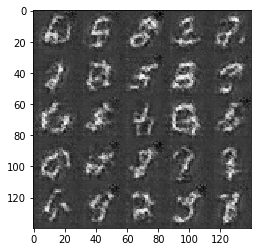

Epoch 1/2... Discriminator Loss: 0.2254 Generator Loss: 2.3031
Epoch 1/2... Discriminator Loss: 1.2007 Generator Loss: 0.4812
Epoch 1/2... Discriminator Loss: 0.2250 Generator Loss: 2.8369
Epoch 1/2... Discriminator Loss: 0.1775 Generator Loss: 2.4696
Epoch 1/2... Discriminator Loss: 1.0687 Generator Loss: 0.5721
Epoch 1/2... Discriminator Loss: 0.2973 Generator Loss: 1.8832
Epoch 1/2... Discriminator Loss: 0.1817 Generator Loss: 2.3875
Epoch 1/2... Discriminator Loss: 0.3210 Generator Loss: 2.3668
Epoch 1/2... Discriminator Loss: 1.1522 Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 0.3966 Generator Loss: 2.3229


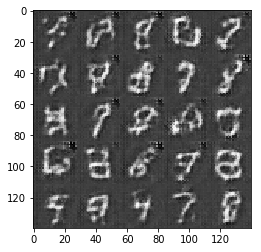

Epoch 1/2... Discriminator Loss: 0.1524 Generator Loss: 2.7106
Epoch 1/2... Discriminator Loss: 0.5362 Generator Loss: 1.8475
Epoch 1/2... Discriminator Loss: 0.9917 Generator Loss: 1.4889
Epoch 1/2... Discriminator Loss: 0.5974 Generator Loss: 1.9839
Epoch 1/2... Discriminator Loss: 0.4546 Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 0.2602 Generator Loss: 3.6219
Epoch 1/2... Discriminator Loss: 0.2720 Generator Loss: 2.9850
Epoch 1/2... Discriminator Loss: 0.4952 Generator Loss: 4.3608
Epoch 1/2... Discriminator Loss: 0.4106 Generator Loss: 1.3682
Epoch 1/2... Discriminator Loss: 0.1390 Generator Loss: 3.7232


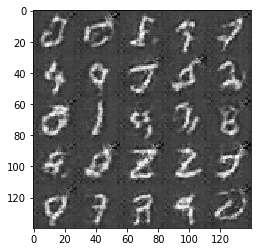

Epoch 1/2... Discriminator Loss: 1.2306 Generator Loss: 4.9435
Epoch 1/2... Discriminator Loss: 0.4354 Generator Loss: 1.2869
Epoch 1/2... Discriminator Loss: 0.5419 Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 0.0829 Generator Loss: 3.6229
Epoch 1/2... Discriminator Loss: 2.6389 Generator Loss: 0.3592
Epoch 1/2... Discriminator Loss: 1.2426 Generator Loss: 0.7676
Epoch 1/2... Discriminator Loss: 1.0652 Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 0.9505 Generator Loss: 0.8055
Epoch 1/2... Discriminator Loss: 0.8703 Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.1885 Generator Loss: 0.4361


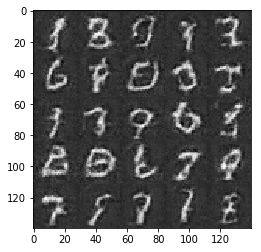

Epoch 1/2... Discriminator Loss: 0.6048 Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 0.6210 Generator Loss: 1.1280
Epoch 1/2... Discriminator Loss: 0.8741 Generator Loss: 2.6416
Epoch 1/2... Discriminator Loss: 0.4546 Generator Loss: 1.8033
Epoch 1/2... Discriminator Loss: 0.6371 Generator Loss: 1.2481
Epoch 1/2... Discriminator Loss: 0.4694 Generator Loss: 3.2425
Epoch 1/2... Discriminator Loss: 1.4039 Generator Loss: 0.3523
Epoch 1/2... Discriminator Loss: 0.4290 Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 0.2132 Generator Loss: 2.2602
Epoch 1/2... Discriminator Loss: 0.1344 Generator Loss: 3.5607


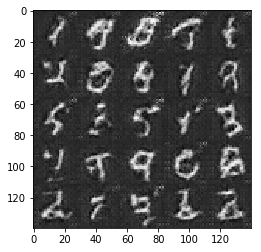

Epoch 1/2... Discriminator Loss: 0.2821 Generator Loss: 1.8242
Epoch 1/2... Discriminator Loss: 0.3352 Generator Loss: 1.6773
Epoch 1/2... Discriminator Loss: 0.0800 Generator Loss: 3.2096
Epoch 1/2... Discriminator Loss: 1.0728 Generator Loss: 0.5467
Epoch 1/2... Discriminator Loss: 0.3939 Generator Loss: 1.5043
Epoch 1/2... Discriminator Loss: 0.1866 Generator Loss: 3.8645
Epoch 1/2... Discriminator Loss: 0.2926 Generator Loss: 3.4072
Epoch 1/2... Discriminator Loss: 0.2024 Generator Loss: 2.7387
Epoch 1/2... Discriminator Loss: 0.5957 Generator Loss: 4.3230
Epoch 1/2... Discriminator Loss: 1.2469 Generator Loss: 0.4738


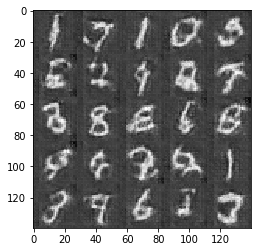

Epoch 1/2... Discriminator Loss: 1.0090 Generator Loss: 0.8032
Epoch 1/2... Discriminator Loss: 1.2425 Generator Loss: 0.4632
Epoch 1/2... Discriminator Loss: 0.2956 Generator Loss: 2.9189
Epoch 1/2... Discriminator Loss: 0.7092 Generator Loss: 0.9988
Epoch 1/2... Discriminator Loss: 0.2100 Generator Loss: 2.6059
Epoch 1/2... Discriminator Loss: 0.1998 Generator Loss: 2.3308
Epoch 1/2... Discriminator Loss: 0.0554 Generator Loss: 4.9256
Epoch 1/2... Discriminator Loss: 2.5362 Generator Loss: 0.1184
Epoch 1/2... Discriminator Loss: 0.8692 Generator Loss: 0.7679
Epoch 1/2... Discriminator Loss: 0.3640 Generator Loss: 1.6877


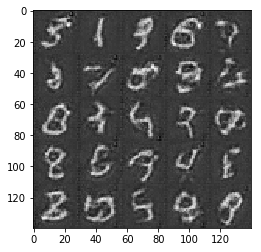

Epoch 1/2... Discriminator Loss: 1.2285 Generator Loss: 0.4463
Epoch 1/2... Discriminator Loss: 0.5952 Generator Loss: 3.4038
Epoch 1/2... Discriminator Loss: 1.7725 Generator Loss: 0.2476
Epoch 1/2... Discriminator Loss: 0.7543 Generator Loss: 2.5274
Epoch 1/2... Discriminator Loss: 0.9359 Generator Loss: 0.7598
Epoch 1/2... Discriminator Loss: 1.2396 Generator Loss: 0.6045
Epoch 1/2... Discriminator Loss: 0.7236 Generator Loss: 1.2997
Epoch 1/2... Discriminator Loss: 0.1770 Generator Loss: 3.1883
Epoch 1/2... Discriminator Loss: 0.3978 Generator Loss: 1.3906
Epoch 1/2... Discriminator Loss: 1.2518 Generator Loss: 0.4930


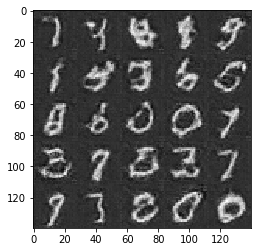

Epoch 1/2... Discriminator Loss: 0.2958 Generator Loss: 3.8967
Epoch 1/2... Discriminator Loss: 0.4103 Generator Loss: 1.3952
Epoch 1/2... Discriminator Loss: 0.2620 Generator Loss: 1.8686
Epoch 1/2... Discriminator Loss: 2.0239 Generator Loss: 0.2652
Epoch 1/2... Discriminator Loss: 0.1504 Generator Loss: 3.2538
Epoch 1/2... Discriminator Loss: 0.8529 Generator Loss: 0.6776
Epoch 1/2... Discriminator Loss: 0.3062 Generator Loss: 1.7112
Epoch 1/2... Discriminator Loss: 0.2088 Generator Loss: 3.7344
Epoch 1/2... Discriminator Loss: 0.5163 Generator Loss: 1.1370
Epoch 1/2... Discriminator Loss: 0.3202 Generator Loss: 1.7653


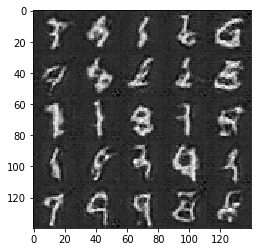

Epoch 1/2... Discriminator Loss: 0.8169 Generator Loss: 1.1346
Epoch 1/2... Discriminator Loss: 0.3978 Generator Loss: 1.5147
Epoch 1/2... Discriminator Loss: 0.9014 Generator Loss: 0.6841
Epoch 1/2... Discriminator Loss: 0.2279 Generator Loss: 1.8364
Epoch 1/2... Discriminator Loss: 1.8977 Generator Loss: 0.2360
Epoch 1/2... Discriminator Loss: 0.1876 Generator Loss: 2.3427
Epoch 1/2... Discriminator Loss: 0.0742 Generator Loss: 3.3879
Epoch 1/2... Discriminator Loss: 1.3317 Generator Loss: 1.2418
Epoch 1/2... Discriminator Loss: 0.5838 Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 0.9043 Generator Loss: 0.7409


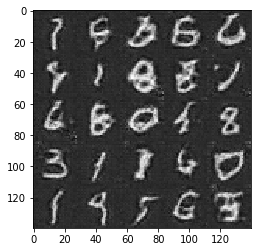

Epoch 1/2... Discriminator Loss: 1.2917 Generator Loss: 0.4425
Epoch 1/2... Discriminator Loss: 1.8593 Generator Loss: 0.2346
Epoch 1/2... Discriminator Loss: 1.1563 Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 1.6740 Generator Loss: 0.3132
Epoch 1/2... Discriminator Loss: 1.8171 Generator Loss: 0.2662
Epoch 1/2... Discriminator Loss: 0.9544 Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.7252 Generator Loss: 0.2926
Epoch 1/2... Discriminator Loss: 0.6430 Generator Loss: 1.0186
Epoch 1/2... Discriminator Loss: 0.3688 Generator Loss: 1.4933
Epoch 1/2... Discriminator Loss: 0.2786 Generator Loss: 1.6913


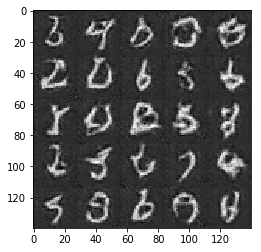

Epoch 1/2... Discriminator Loss: 0.9123 Generator Loss: 1.3884
Epoch 1/2... Discriminator Loss: 0.5472 Generator Loss: 1.1441
Epoch 1/2... Discriminator Loss: 0.9216 Generator Loss: 0.6436
Epoch 1/2... Discriminator Loss: 0.1911 Generator Loss: 2.3416
Epoch 1/2... Discriminator Loss: 0.4803 Generator Loss: 1.7611
Epoch 1/2... Discriminator Loss: 0.4866 Generator Loss: 1.3193
Epoch 1/2... Discriminator Loss: 0.4164 Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 0.5946 Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 0.1094 Generator Loss: 2.9897
Epoch 1/2... Discriminator Loss: 1.0093 Generator Loss: 0.9220


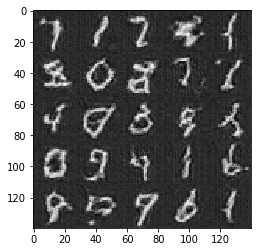

Epoch 1/2... Discriminator Loss: 0.7185 Generator Loss: 1.0322
Epoch 1/2... Discriminator Loss: 2.4030 Generator Loss: 0.1324
Epoch 1/2... Discriminator Loss: 1.2908 Generator Loss: 0.4809
Epoch 1/2... Discriminator Loss: 1.0432 Generator Loss: 1.3276
Epoch 1/2... Discriminator Loss: 0.9607 Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 0.8718 Generator Loss: 1.1030
Epoch 1/2... Discriminator Loss: 0.9809 Generator Loss: 1.2693
Epoch 2/2... Discriminator Loss: 0.9098 Generator Loss: 0.8261
Epoch 2/2... Discriminator Loss: 1.0199 Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 0.5863 Generator Loss: 1.2161


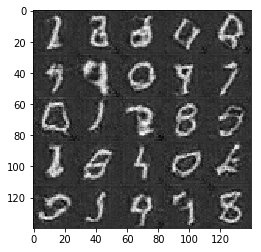

Epoch 2/2... Discriminator Loss: 0.8197 Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 1.4291 Generator Loss: 0.3883
Epoch 2/2... Discriminator Loss: 0.4090 Generator Loss: 1.6192
Epoch 2/2... Discriminator Loss: 1.3082 Generator Loss: 0.3964
Epoch 2/2... Discriminator Loss: 0.9278 Generator Loss: 0.6712
Epoch 2/2... Discriminator Loss: 0.1532 Generator Loss: 2.8622
Epoch 2/2... Discriminator Loss: 0.8435 Generator Loss: 0.7808
Epoch 2/2... Discriminator Loss: 1.0430 Generator Loss: 0.7181
Epoch 2/2... Discriminator Loss: 1.0465 Generator Loss: 0.6796
Epoch 2/2... Discriminator Loss: 1.4126 Generator Loss: 0.4141


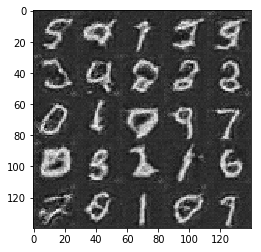

Epoch 2/2... Discriminator Loss: 0.9296 Generator Loss: 0.7751
Epoch 2/2... Discriminator Loss: 0.1537 Generator Loss: 3.8760
Epoch 2/2... Discriminator Loss: 0.1095 Generator Loss: 3.2086
Epoch 2/2... Discriminator Loss: 0.1657 Generator Loss: 2.7659
Epoch 2/2... Discriminator Loss: 2.2751 Generator Loss: 0.1445
Epoch 2/2... Discriminator Loss: 0.1246 Generator Loss: 3.1149
Epoch 2/2... Discriminator Loss: 0.8104 Generator Loss: 1.3532
Epoch 2/2... Discriminator Loss: 1.6275 Generator Loss: 0.4870
Epoch 2/2... Discriminator Loss: 0.7333 Generator Loss: 1.0131
Epoch 2/2... Discriminator Loss: 1.2284 Generator Loss: 0.4806


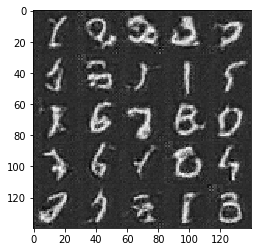

Epoch 2/2... Discriminator Loss: 0.2304 Generator Loss: 2.9903
Epoch 2/2... Discriminator Loss: 0.1830 Generator Loss: 2.3119
Epoch 2/2... Discriminator Loss: 0.2017 Generator Loss: 2.1883
Epoch 2/2... Discriminator Loss: 0.2470 Generator Loss: 1.8208
Epoch 2/2... Discriminator Loss: 1.3009 Generator Loss: 0.4309
Epoch 2/2... Discriminator Loss: 1.3514 Generator Loss: 0.4351
Epoch 2/2... Discriminator Loss: 0.8789 Generator Loss: 0.6570
Epoch 2/2... Discriminator Loss: 0.7655 Generator Loss: 0.8233
Epoch 2/2... Discriminator Loss: 0.4276 Generator Loss: 1.4181
Epoch 2/2... Discriminator Loss: 0.0643 Generator Loss: 3.7770


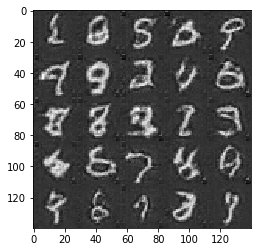

Epoch 2/2... Discriminator Loss: 0.0353 Generator Loss: 4.3216
Epoch 2/2... Discriminator Loss: 0.4423 Generator Loss: 2.6798
Epoch 2/2... Discriminator Loss: 0.6833 Generator Loss: 1.4061
Epoch 2/2... Discriminator Loss: 0.9047 Generator Loss: 0.6681
Epoch 2/2... Discriminator Loss: 0.1017 Generator Loss: 3.4601
Epoch 2/2... Discriminator Loss: 1.1896 Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 2.1107 Generator Loss: 0.1917
Epoch 2/2... Discriminator Loss: 0.7313 Generator Loss: 0.9565
Epoch 2/2... Discriminator Loss: 1.9898 Generator Loss: 0.1965
Epoch 2/2... Discriminator Loss: 2.5208 Generator Loss: 0.1358


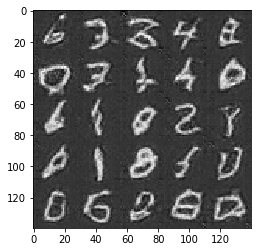

Epoch 2/2... Discriminator Loss: 1.2505 Generator Loss: 0.7938
Epoch 2/2... Discriminator Loss: 0.9173 Generator Loss: 0.9480
Epoch 2/2... Discriminator Loss: 0.8915 Generator Loss: 0.9428
Epoch 2/2... Discriminator Loss: 0.9330 Generator Loss: 0.9799
Epoch 2/2... Discriminator Loss: 0.9328 Generator Loss: 0.7789
Epoch 2/2... Discriminator Loss: 1.1473 Generator Loss: 0.5154
Epoch 2/2... Discriminator Loss: 0.8311 Generator Loss: 1.0827
Epoch 2/2... Discriminator Loss: 0.7432 Generator Loss: 0.9705
Epoch 2/2... Discriminator Loss: 0.2828 Generator Loss: 2.7794
Epoch 2/2... Discriminator Loss: 2.8828 Generator Loss: 0.0931


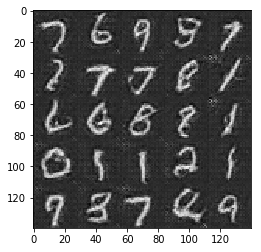

Epoch 2/2... Discriminator Loss: 1.2473 Generator Loss: 0.4943
Epoch 2/2... Discriminator Loss: 1.2351 Generator Loss: 0.4556
Epoch 2/2... Discriminator Loss: 0.7630 Generator Loss: 0.8628
Epoch 2/2... Discriminator Loss: 0.1906 Generator Loss: 2.9518
Epoch 2/2... Discriminator Loss: 2.0333 Generator Loss: 0.2309
Epoch 2/2... Discriminator Loss: 0.6510 Generator Loss: 1.0633
Epoch 2/2... Discriminator Loss: 0.4044 Generator Loss: 1.5771
Epoch 2/2... Discriminator Loss: 0.4835 Generator Loss: 1.4529
Epoch 2/2... Discriminator Loss: 0.9794 Generator Loss: 4.5242
Epoch 2/2... Discriminator Loss: 2.1734 Generator Loss: 0.1713


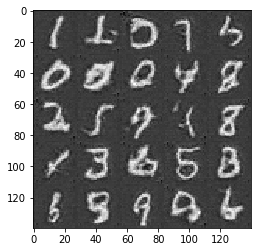

Epoch 2/2... Discriminator Loss: 2.0439 Generator Loss: 0.2295
Epoch 2/2... Discriminator Loss: 0.2545 Generator Loss: 2.1971
Epoch 2/2... Discriminator Loss: 1.9688 Generator Loss: 0.2433
Epoch 2/2... Discriminator Loss: 0.1373 Generator Loss: 5.0947
Epoch 2/2... Discriminator Loss: 0.3818 Generator Loss: 1.5856
Epoch 2/2... Discriminator Loss: 2.5618 Generator Loss: 0.1503
Epoch 2/2... Discriminator Loss: 1.7541 Generator Loss: 0.3536
Epoch 2/2... Discriminator Loss: 0.1075 Generator Loss: 3.3978
Epoch 2/2... Discriminator Loss: 0.4479 Generator Loss: 1.3253
Epoch 2/2... Discriminator Loss: 0.0533 Generator Loss: 3.8592


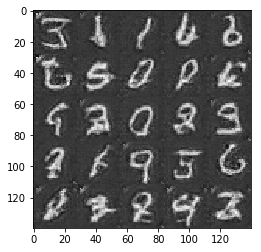

Epoch 2/2... Discriminator Loss: 1.9968 Generator Loss: 0.2117
Epoch 2/2... Discriminator Loss: 2.2247 Generator Loss: 0.1962
Epoch 2/2... Discriminator Loss: 0.0661 Generator Loss: 4.4514
Epoch 2/2... Discriminator Loss: 0.5900 Generator Loss: 1.9812
Epoch 2/2... Discriminator Loss: 2.4073 Generator Loss: 0.1854
Epoch 2/2... Discriminator Loss: 0.9552 Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 0.9691 Generator Loss: 0.9528
Epoch 2/2... Discriminator Loss: 0.7977 Generator Loss: 1.3515
Epoch 2/2... Discriminator Loss: 0.9474 Generator Loss: 1.8863
Epoch 2/2... Discriminator Loss: 1.6275 Generator Loss: 0.4685


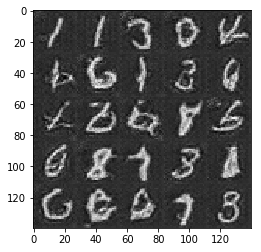

Epoch 2/2... Discriminator Loss: 0.6771 Generator Loss: 1.3675
Epoch 2/2... Discriminator Loss: 1.3442 Generator Loss: 0.3946
Epoch 2/2... Discriminator Loss: 1.0491 Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 0.7855 Generator Loss: 2.7261
Epoch 2/2... Discriminator Loss: 0.5506 Generator Loss: 1.4430
Epoch 2/2... Discriminator Loss: 1.3285 Generator Loss: 0.5355
Epoch 2/2... Discriminator Loss: 1.0681 Generator Loss: 0.6263
Epoch 2/2... Discriminator Loss: 1.5327 Generator Loss: 0.3650
Epoch 2/2... Discriminator Loss: 1.8641 Generator Loss: 0.2273
Epoch 2/2... Discriminator Loss: 0.8986 Generator Loss: 0.6762


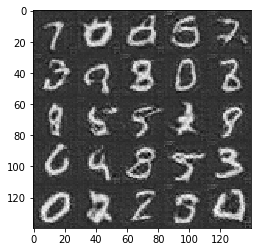

Epoch 2/2... Discriminator Loss: 1.7877 Generator Loss: 0.2321
Epoch 2/2... Discriminator Loss: 1.1337 Generator Loss: 0.5621
Epoch 2/2... Discriminator Loss: 0.3432 Generator Loss: 2.0040
Epoch 2/2... Discriminator Loss: 1.2004 Generator Loss: 0.5194
Epoch 2/2... Discriminator Loss: 1.0547 Generator Loss: 0.7610
Epoch 2/2... Discriminator Loss: 0.7293 Generator Loss: 0.8527
Epoch 2/2... Discriminator Loss: 1.3614 Generator Loss: 0.4007
Epoch 2/2... Discriminator Loss: 0.0836 Generator Loss: 3.9179
Epoch 2/2... Discriminator Loss: 1.6719 Generator Loss: 0.3147
Epoch 2/2... Discriminator Loss: 0.1378 Generator Loss: 2.7778


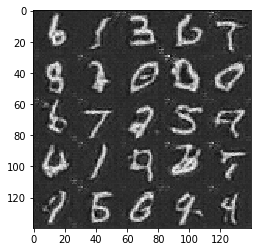

Epoch 2/2... Discriminator Loss: 0.3300 Generator Loss: 2.4626
Epoch 2/2... Discriminator Loss: 0.1556 Generator Loss: 6.6464
Epoch 2/2... Discriminator Loss: 0.2810 Generator Loss: 2.2733
Epoch 2/2... Discriminator Loss: 0.0890 Generator Loss: 3.4292
Epoch 2/2... Discriminator Loss: 0.7701 Generator Loss: 0.9035
Epoch 2/2... Discriminator Loss: 0.0753 Generator Loss: 4.6681
Epoch 2/2... Discriminator Loss: 0.2468 Generator Loss: 1.9072
Epoch 2/2... Discriminator Loss: 2.6069 Generator Loss: 3.9553
Epoch 2/2... Discriminator Loss: 0.4811 Generator Loss: 1.3813
Epoch 2/2... Discriminator Loss: 0.2385 Generator Loss: 2.2886


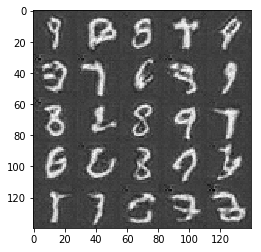

Epoch 2/2... Discriminator Loss: 1.3802 Generator Loss: 0.4204
Epoch 2/2... Discriminator Loss: 1.6386 Generator Loss: 0.3770
Epoch 2/2... Discriminator Loss: 1.1375 Generator Loss: 0.5278
Epoch 2/2... Discriminator Loss: 1.5793 Generator Loss: 0.3732
Epoch 2/2... Discriminator Loss: 1.4241 Generator Loss: 0.8654
Epoch 2/2... Discriminator Loss: 0.9107 Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 1.4355 Generator Loss: 0.3647
Epoch 2/2... Discriminator Loss: 2.1552 Generator Loss: 0.1669
Epoch 2/2... Discriminator Loss: 0.8751 Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 0.2184 Generator Loss: 7.8337


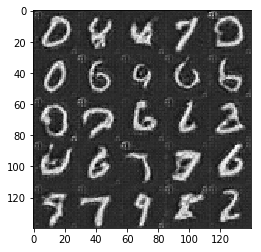

Epoch 2/2... Discriminator Loss: 0.9255 Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.0047 Generator Loss: 0.7336
Epoch 2/2... Discriminator Loss: 1.8422 Generator Loss: 0.2737
Epoch 2/2... Discriminator Loss: 0.1683 Generator Loss: 2.6938
Epoch 2/2... Discriminator Loss: 0.0921 Generator Loss: 3.3612
Epoch 2/2... Discriminator Loss: 1.5620 Generator Loss: 2.0327
Epoch 2/2... Discriminator Loss: 0.7585 Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 1.1106 Generator Loss: 0.5792
Epoch 2/2... Discriminator Loss: 0.5898 Generator Loss: 1.7754
Epoch 2/2... Discriminator Loss: 1.8885 Generator Loss: 0.2597


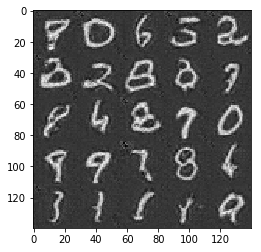

Epoch 2/2... Discriminator Loss: 0.3519 Generator Loss: 1.6299
Epoch 2/2... Discriminator Loss: 2.1915 Generator Loss: 0.2016
Epoch 2/2... Discriminator Loss: 0.8162 Generator Loss: 0.9943
Epoch 2/2... Discriminator Loss: 1.1454 Generator Loss: 0.5845
Epoch 2/2... Discriminator Loss: 0.9850 Generator Loss: 0.6312
Epoch 2/2... Discriminator Loss: 0.8423 Generator Loss: 0.7785
Epoch 2/2... Discriminator Loss: 1.1068 Generator Loss: 0.5807
Epoch 2/2... Discriminator Loss: 0.3109 Generator Loss: 2.2137
Epoch 2/2... Discriminator Loss: 0.4009 Generator Loss: 1.6116
Epoch 2/2... Discriminator Loss: 0.9950 Generator Loss: 0.7612


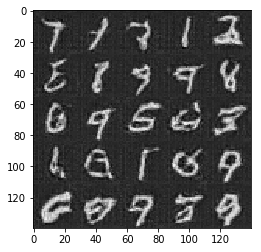

Epoch 2/2... Discriminator Loss: 1.0770 Generator Loss: 0.6693
Epoch 2/2... Discriminator Loss: 0.7307 Generator Loss: 1.1801
Epoch 2/2... Discriminator Loss: 1.4667 Generator Loss: 0.3773
Epoch 2/2... Discriminator Loss: 2.1137 Generator Loss: 0.2392
Epoch 2/2... Discriminator Loss: 0.1112 Generator Loss: 3.0925
Epoch 2/2... Discriminator Loss: 0.1044 Generator Loss: 4.2373
Epoch 2/2... Discriminator Loss: 0.0604 Generator Loss: 5.0861
Epoch 2/2... Discriminator Loss: 1.5503 Generator Loss: 0.3865
Epoch 2/2... Discriminator Loss: 0.8415 Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 0.0271 Generator Loss: 4.7657


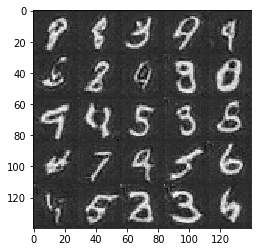

Epoch 2/2... Discriminator Loss: 0.2017 Generator Loss: 2.2542
Epoch 2/2... Discriminator Loss: 0.0113 Generator Loss: 7.0464
Epoch 2/2... Discriminator Loss: 0.1045 Generator Loss: 4.0066
Epoch 2/2... Discriminator Loss: 0.1123 Generator Loss: 2.8086
Epoch 2/2... Discriminator Loss: 0.2246 Generator Loss: 2.7996
Epoch 2/2... Discriminator Loss: 0.0506 Generator Loss: 3.5570
Epoch 2/2... Discriminator Loss: 0.0266 Generator Loss: 4.3342
Epoch 2/2... Discriminator Loss: 0.0435 Generator Loss: 4.0357
Epoch 2/2... Discriminator Loss: 0.0372 Generator Loss: 3.9439
Epoch 2/2... Discriminator Loss: 0.0309 Generator Loss: 4.0239


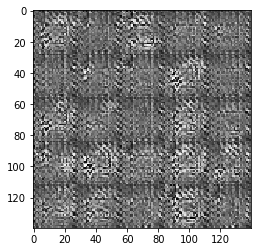

Epoch 2/2... Discriminator Loss: 0.0374 Generator Loss: 3.8166
Epoch 2/2... Discriminator Loss: 0.0325 Generator Loss: 3.9984
Epoch 2/2... Discriminator Loss: 0.0367 Generator Loss: 3.8729
Epoch 2/2... Discriminator Loss: 0.2418 Generator Loss: 1.8842
Epoch 2/2... Discriminator Loss: 0.0281 Generator Loss: 4.1607
Epoch 2/2... Discriminator Loss: 0.0246 Generator Loss: 4.3984
Epoch 2/2... Discriminator Loss: 0.0066 Generator Loss: 5.9086
Epoch 2/2... Discriminator Loss: 0.0104 Generator Loss: 5.1961
Epoch 2/2... Discriminator Loss: 0.0147 Generator Loss: 5.2286
Epoch 2/2... Discriminator Loss: 0.0194 Generator Loss: 4.9330


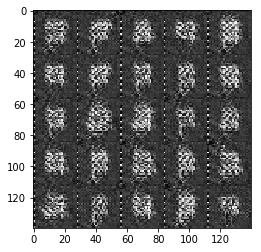

Epoch 2/2... Discriminator Loss: 0.0137 Generator Loss: 5.0365
Epoch 2/2... Discriminator Loss: 0.0078 Generator Loss: 6.8642
Epoch 2/2... Discriminator Loss: 0.0413 Generator Loss: 3.7877
Epoch 2/2... Discriminator Loss: 0.0043 Generator Loss: 6.9509
Epoch 2/2... Discriminator Loss: 0.0145 Generator Loss: 5.0668
Epoch 2/2... Discriminator Loss: 0.0303 Generator Loss: 4.0724
Epoch 2/2... Discriminator Loss: 0.0062 Generator Loss: 6.3413
Epoch 2/2... Discriminator Loss: 0.0831 Generator Loss: 3.1669
Epoch 2/2... Discriminator Loss: 0.0534 Generator Loss: 3.2444
Epoch 2/2... Discriminator Loss: 0.0111 Generator Loss: 6.1242


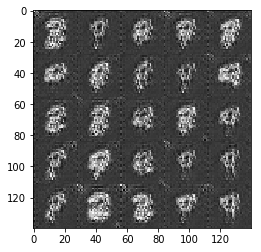

Epoch 2/2... Discriminator Loss: 0.2461 Generator Loss: 1.8900
Epoch 2/2... Discriminator Loss: 0.0080 Generator Loss: 6.4331
Epoch 2/2... Discriminator Loss: 0.0579 Generator Loss: 3.3545
Epoch 2/2... Discriminator Loss: 0.0506 Generator Loss: 3.4861
Epoch 2/2... Discriminator Loss: 0.0356 Generator Loss: 3.9472


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 7.8687 Generator Loss: 0.0083
Epoch 1/1... Discriminator Loss: 1.1643 Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.1228 Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.5329 Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 0.6100 Generator Loss: 3.8357
Epoch 1/1... Discriminator Loss: 0.7004 Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 0.0363 Generator Loss: 3.9449
Epoch 1/1... Discriminator Loss: 0.0033 Generator Loss: 8.7489
Epoch 1/1... Discriminator Loss: 0.0723 Generator Loss: 8.3191
Epoch 1/1... Discriminator Loss: 0.0149 Generator Loss: 8.6813


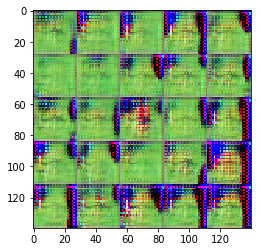

Epoch 1/1... Discriminator Loss: 1.4332 Generator Loss: 2.8037
Epoch 1/1... Discriminator Loss: 1.1918 Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 0.1032 Generator Loss: 3.5441
Epoch 1/1... Discriminator Loss: 1.2453 Generator Loss: 4.5704
Epoch 1/1... Discriminator Loss: 1.3739 Generator Loss: 2.3486
Epoch 1/1... Discriminator Loss: 0.5714 Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 0.4279 Generator Loss: 1.7687
Epoch 1/1... Discriminator Loss: 2.3890 Generator Loss: 5.5224
Epoch 1/1... Discriminator Loss: 1.7821 Generator Loss: 0.2848
Epoch 1/1... Discriminator Loss: 0.2554 Generator Loss: 2.3041


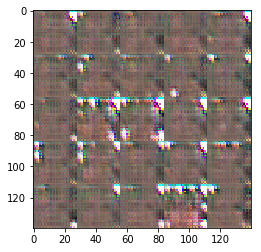

Epoch 1/1... Discriminator Loss: 0.3058 Generator Loss: 1.8483
Epoch 1/1... Discriminator Loss: 0.9223 Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 0.3441 Generator Loss: 1.5970
Epoch 1/1... Discriminator Loss: 0.1653 Generator Loss: 2.7979
Epoch 1/1... Discriminator Loss: 0.0538 Generator Loss: 4.1909
Epoch 1/1... Discriminator Loss: 0.0761 Generator Loss: 3.8662
Epoch 1/1... Discriminator Loss: 0.0736 Generator Loss: 4.8446
Epoch 1/1... Discriminator Loss: 2.6510 Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 0.5439 Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.7610 Generator Loss: 0.8992


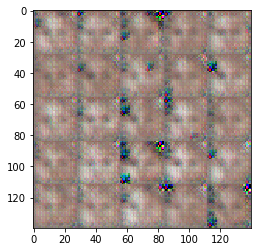

Epoch 1/1... Discriminator Loss: 0.4730 Generator Loss: 1.3988
Epoch 1/1... Discriminator Loss: 0.1648 Generator Loss: 2.8913
Epoch 1/1... Discriminator Loss: 0.1215 Generator Loss: 2.5424
Epoch 1/1... Discriminator Loss: 3.1542 Generator Loss: 4.1055
Epoch 1/1... Discriminator Loss: 2.0625 Generator Loss: 0.3151
Epoch 1/1... Discriminator Loss: 1.8380 Generator Loss: 0.3091
Epoch 1/1... Discriminator Loss: 1.4207 Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3631 Generator Loss: 0.4621
Epoch 1/1... Discriminator Loss: 1.2771 Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.2144 Generator Loss: 0.9321


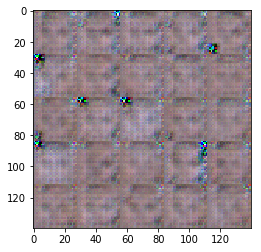

Epoch 1/1... Discriminator Loss: 0.6551 Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 1.3347 Generator Loss: 0.4784
Epoch 1/1... Discriminator Loss: 1.4055 Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.5089 Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.5292 Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.4342 Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.7787 Generator Loss: 0.4296
Epoch 1/1... Discriminator Loss: 1.6160 Generator Loss: 0.5308
Epoch 1/1... Discriminator Loss: 1.3286 Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 1.4492 Generator Loss: 0.6221


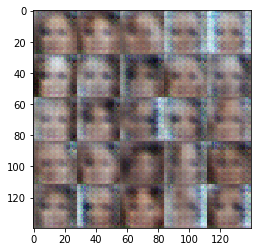

Epoch 1/1... Discriminator Loss: 1.4891 Generator Loss: 0.5238
Epoch 1/1... Discriminator Loss: 1.5850 Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.5364 Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.4337 Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.5989 Generator Loss: 0.4557
Epoch 1/1... Discriminator Loss: 1.4765 Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4805 Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.5327 Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.4561 Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.4981 Generator Loss: 0.5887


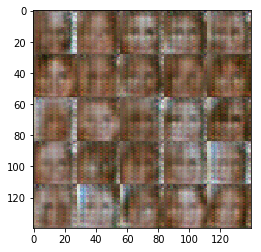

Epoch 1/1... Discriminator Loss: 1.3524 Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4730 Generator Loss: 0.6206
Epoch 1/1... Discriminator Loss: 1.4762 Generator Loss: 0.6001
Epoch 1/1... Discriminator Loss: 1.2876 Generator Loss: 0.6606
Epoch 1/1... Discriminator Loss: 1.4176 Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4451 Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.4132 Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.5060 Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 1.5631 Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.4248 Generator Loss: 0.6779


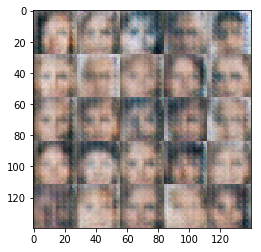

Epoch 1/1... Discriminator Loss: 1.3557 Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4870 Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.5124 Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.3920 Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.4044 Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.4069 Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.5260 Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.3701 Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3949 Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.3854 Generator Loss: 0.7141


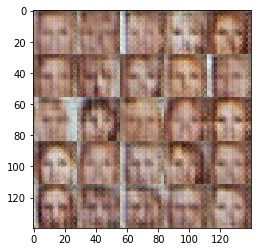

Epoch 1/1... Discriminator Loss: 1.4357 Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.4650 Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.3193 Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.3922 Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.4696 Generator Loss: 0.6327
Epoch 1/1... Discriminator Loss: 1.4024 Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.4751 Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.3768 Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.5337 Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4705 Generator Loss: 0.6294


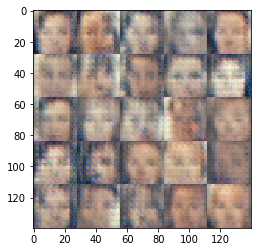

Epoch 1/1... Discriminator Loss: 1.5624 Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4544 Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.3216 Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.4546 Generator Loss: 0.5475
Epoch 1/1... Discriminator Loss: 1.4178 Generator Loss: 0.6138
Epoch 1/1... Discriminator Loss: 1.5082 Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.5222 Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.3450 Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4795 Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.4151 Generator Loss: 0.5836


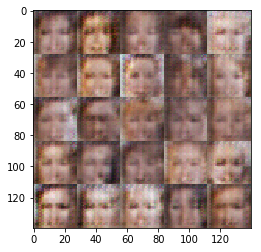

Epoch 1/1... Discriminator Loss: 1.4387 Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4403 Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.6391 Generator Loss: 0.5361
Epoch 1/1... Discriminator Loss: 1.4469 Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.5830 Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.4116 Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.4539 Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.4601 Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4128 Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.5057 Generator Loss: 0.5612


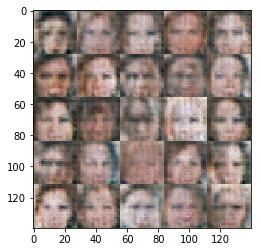

Epoch 1/1... Discriminator Loss: 1.5779 Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.5492 Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.4951 Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.4792 Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4174 Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.4699 Generator Loss: 0.5744
Epoch 1/1... Discriminator Loss: 1.5604 Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4308 Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.4567 Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4124 Generator Loss: 0.6343


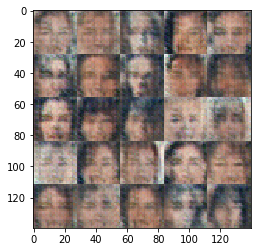

Epoch 1/1... Discriminator Loss: 1.4665 Generator Loss: 0.5756
Epoch 1/1... Discriminator Loss: 1.4846 Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.4480 Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.3709 Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.4513 Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.4907 Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.4541 Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.4027 Generator Loss: 0.5776
Epoch 1/1... Discriminator Loss: 1.4749 Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.3978 Generator Loss: 0.6468


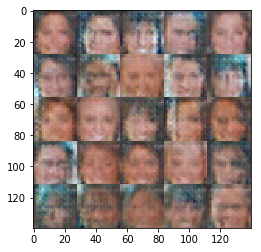

Epoch 1/1... Discriminator Loss: 1.4459 Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.4242 Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 1.4898 Generator Loss: 0.5441
Epoch 1/1... Discriminator Loss: 1.5322 Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.4766 Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4533 Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.4863 Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.4019 Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4129 Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.4245 Generator Loss: 0.6311


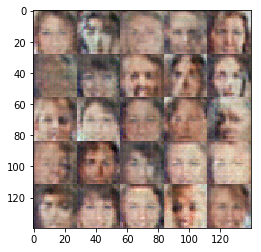

Epoch 1/1... Discriminator Loss: 1.3885 Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.4054 Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.4606 Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.4268 Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 1.3978 Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.4422 Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3874 Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.4438 Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.5302 Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.4880 Generator Loss: 0.6627


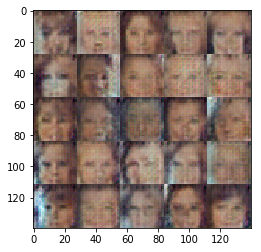

Epoch 1/1... Discriminator Loss: 1.4750 Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4309 Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4202 Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4727 Generator Loss: 0.5800
Epoch 1/1... Discriminator Loss: 1.4222 Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.4142 Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.4371 Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.4294 Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.5008 Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.3811 Generator Loss: 0.6103


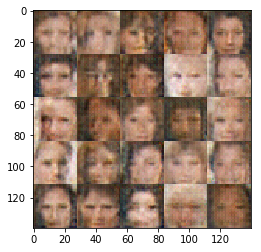

Epoch 1/1... Discriminator Loss: 1.5158 Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.4535 Generator Loss: 0.6041
Epoch 1/1... Discriminator Loss: 1.4507 Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 1.4317 Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.3990 Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.3900 Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.4321 Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.4087 Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4256 Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.5436 Generator Loss: 0.5502


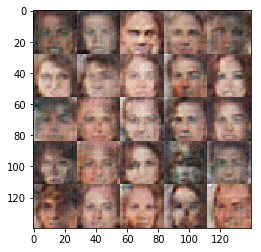

Epoch 1/1... Discriminator Loss: 1.3975 Generator Loss: 0.5921
Epoch 1/1... Discriminator Loss: 1.4175 Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4205 Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.4099 Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.4330 Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.4214 Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.4346 Generator Loss: 0.5470
Epoch 1/1... Discriminator Loss: 1.4325 Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4191 Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.4437 Generator Loss: 0.6246


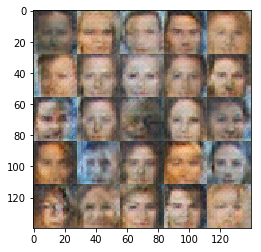

Epoch 1/1... Discriminator Loss: 1.5023 Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3832 Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.4521 Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.4065 Generator Loss: 0.6412
Epoch 1/1... Discriminator Loss: 1.4697 Generator Loss: 0.5791
Epoch 1/1... Discriminator Loss: 1.4168 Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.4480 Generator Loss: 0.6304
Epoch 1/1... Discriminator Loss: 1.4433 Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4357 Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.4258 Generator Loss: 0.6858


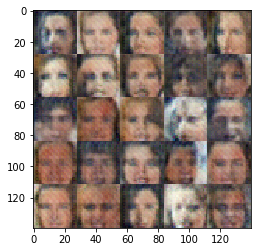

Epoch 1/1... Discriminator Loss: 1.4593 Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4387 Generator Loss: 0.6172
Epoch 1/1... Discriminator Loss: 1.4329 Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.5224 Generator Loss: 0.5998
Epoch 1/1... Discriminator Loss: 1.4930 Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.5031 Generator Loss: 0.5105
Epoch 1/1... Discriminator Loss: 1.4517 Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.4289 Generator Loss: 0.5567
Epoch 1/1... Discriminator Loss: 1.4975 Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.4559 Generator Loss: 0.6412


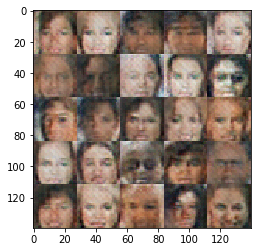

Epoch 1/1... Discriminator Loss: 1.4557 Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.4190 Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.4949 Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.4231 Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4297 Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.5087 Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.4228 Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4209 Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.4416 Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.4159 Generator Loss: 0.7207


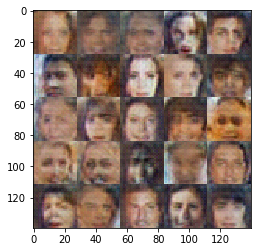

Epoch 1/1... Discriminator Loss: 1.3935 Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4490 Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4542 Generator Loss: 0.5630
Epoch 1/1... Discriminator Loss: 1.4415 Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.3951 Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.4348 Generator Loss: 0.6353
Epoch 1/1... Discriminator Loss: 1.4742 Generator Loss: 0.5384
Epoch 1/1... Discriminator Loss: 1.4356 Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4646 Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.4115 Generator Loss: 0.6798


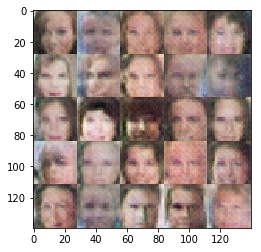

Epoch 1/1... Discriminator Loss: 1.4431 Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.5017 Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4499 Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4427 Generator Loss: 0.6544
Epoch 1/1... Discriminator Loss: 1.4360 Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.3961 Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.4175 Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.4264 Generator Loss: 0.6390
Epoch 1/1... Discriminator Loss: 1.4173 Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.4479 Generator Loss: 0.6186


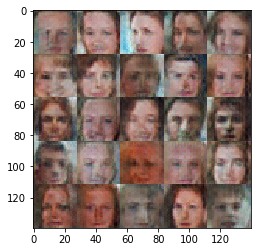

Epoch 1/1... Discriminator Loss: 1.4530 Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.4315 Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.4378 Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.4336 Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4304 Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4681 Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.4024 Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4137 Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.3963 Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4247 Generator Loss: 0.6361


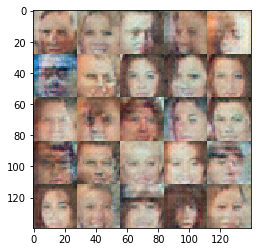

Epoch 1/1... Discriminator Loss: 1.4229 Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.4020 Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4800 Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.5053 Generator Loss: 0.5841
Epoch 1/1... Discriminator Loss: 1.4249 Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.4100 Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4648 Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.4368 Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.4236 Generator Loss: 0.6080
Epoch 1/1... Discriminator Loss: 1.4179 Generator Loss: 0.5821


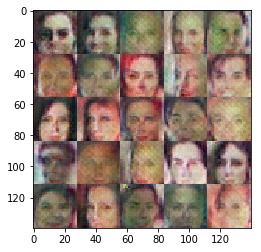

Epoch 1/1... Discriminator Loss: 1.4768 Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.4543 Generator Loss: 0.5224
Epoch 1/1... Discriminator Loss: 1.4331 Generator Loss: 0.6354
Epoch 1/1... Discriminator Loss: 1.4314 Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4248 Generator Loss: 0.6721
Epoch 1/1... Discriminator Loss: 1.4634 Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4525 Generator Loss: 0.5090
Epoch 1/1... Discriminator Loss: 1.4497 Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.4520 Generator Loss: 0.5850
Epoch 1/1... Discriminator Loss: 1.4091 Generator Loss: 0.6242


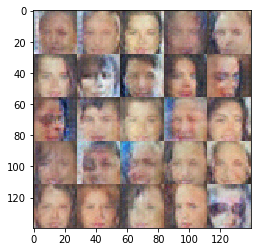

Epoch 1/1... Discriminator Loss: 1.4485 Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.4708 Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.4180 Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.4290 Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.4551 Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.4142 Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4355 Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4750 Generator Loss: 0.4893
Epoch 1/1... Discriminator Loss: 1.4735 Generator Loss: 0.5680
Epoch 1/1... Discriminator Loss: 1.4334 Generator Loss: 0.6561


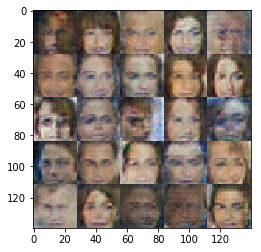

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.